In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]= (20,10)

The realtor-data.csv file comes from a Kaggle dataset that webscrapped information from realtor.com

Link to dataset: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [2]:
df1 = pd.read_csv('realtor-data.csv')
df1.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [3]:
df1.shape

(923159, 12)

In [4]:
df1.groupby('state')['state'].agg('count')

state
Connecticut        91644
Delaware            2135
Georgia               50
Maine              36650
Massachusetts     175248
New Hampshire      51394
New Jersey        233722
New York          211778
Pennsylvania       17148
Puerto Rico        24679
Rhode Island       29596
South Carolina        25
Tennessee             20
Vermont            46460
Virgin Islands      2573
Virginia              31
West Virginia          3
Wyoming                3
Name: state, dtype: int64

The code below gets rid of columns in the dataframe that don't have an effect on price.

In [5]:
df2 = df1.drop(['status', 'full_address', 'street', 'zip_code', 'sold_date'],axis='columns')
df2.head()

,price,bed,bath,acre_lot,city,state,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0
4,65000.0,6.0,2.0,0.05,Mayaguez,Puerto Rico,NaN


In [6]:
df2.isnull().sum()

price             71
bed           131703
bath          115192
acre_lot      273623
city              74
state              0
house_size    297843
dtype: int64

If the lot size is not available put zero in place, could be something like a condo where the is no actual yard.

In [7]:
df2.acre_lot.fillna(0, inplace = True)
df2.isnull().sum()

price             71
bed           131703
bath          115192
acre_lot           0
city              74
state              0
house_size    297843
dtype: int64

The code below gets rid of house entries with missing data.

In [8]:
df3= df2.dropna()
df3.isnull().sum()

price         0
bed           0
bath          0
acre_lot      0
city          0
state         0
house_size    0
dtype: int64

In [9]:
df4 = df3.copy()
df4['price_per_sqft']= df4['price']/df4['house_size']
df4.head()

,price,bed,bath,acre_lot,city,state,house_size,price_per_sqft
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,114.130435
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,52.390308
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,89.572193
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,80.555556
5,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,2520.0,71.031746


In [10]:
len(df4.city.unique())

2323

In [11]:
len(df4[df4.house_size/df4.bed<50])

45

In [12]:
df4.shape

(601978, 8)

The code below deletes houses from states with a small sample size.

In [13]:
df5 = df4[df4.state != 'Wyoming']
df5 = df5[df5.state != 'West Virginia']
df5 = df5[df5.state != 'Georgia']

In [14]:
df5.groupby('state')['state'].agg('count')

state
Connecticut        79909
Delaware            1883
Maine              24524
Massachusetts     148167
New Hampshire      32171
New Jersey         98875
New York          123997
Pennsylvania       14813
Puerto Rico        20946
Rhode Island       28144
Vermont            27998
Virgin Islands       497
Name: state, dtype: int64

In [15]:
df5.shape

(601924, 8)

The function below removes outliers in the dataset.

In [16]:
def remove_outliers1(df):
    out = pd.DataFrame()
    for key, sub in df.groupby('state'):
        m = np.mean(sub.price_per_sqft)
        s = np.std(sub.price_per_sqft)
        q1 = np.quantile(sub.price_per_sqft, 0.25)
        q3 = np.quantile(sub.price_per_sqft, 0.75)
        iqr = q3 - q1
        upper = q3 + (iqr * 1.5)
        lower = q1 - (iqr * 1.5)
        new_df = sub[(sub.price_per_sqft>lower) & (sub.price_per_sqft<upper)]
        out = pd.concat([out, new_df], ignore_index=True)
    return out

df6 = remove_outliers1(df5)
df6.shape

(563231, 8)

In [17]:
df7 = df6.drop(['city'], axis='columns')

The code below implements one-hot encoding.

In [18]:
#one-hot encoding
dummies = pd.get_dummies(df7.state)
dummies.head(15)

,Connecticut,Delaware,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont,Virgin Islands
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
df8 = pd.concat([df7, dummies.drop('Virgin Islands', axis='columns')], axis='columns')
df8.head(5)

,price,bed,bath,acre_lot,state,house_size,price_per_sqft,Connecticut,Delaware,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont
0,225000.0,3.0,1.0,3.93,Connecticut,1572.0,143.129771,1,0,0,0,0,0,0,0,0,0,0
1,579900.0,4.0,3.0,2.34,Connecticut,3320.0,174.668675,1,0,0,0,0,0,0,0,0,0,0
2,65000.0,1.0,1.0,0.00,Connecticut,680.0,95.588235,1,0,0,0,0,0,0,0,0,0,0
3,215000.0,2.0,1.0,0.91,Connecticut,960.0,223.958333,1,0,0,0,0,0,0,0,0,0,0
4,144900.0,2.0,1.0,0.36,Connecticut,860.0,168.488372,1,0,0,0,0,0,0,0,0,0,0


In [20]:
df9 = df8.drop(['state'], axis='columns')
df9.head(5)

,price,bed,bath,acre_lot,house_size,price_per_sqft,Connecticut,Delaware,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont
0,225000.0,3.0,1.0,3.93,1572.0,143.129771,1,0,0,0,0,0,0,0,0,0,0
1,579900.0,4.0,3.0,2.34,3320.0,174.668675,1,0,0,0,0,0,0,0,0,0,0
2,65000.0,1.0,1.0,0.00,680.0,95.588235,1,0,0,0,0,0,0,0,0,0,0
3,215000.0,2.0,1.0,0.91,960.0,223.958333,1,0,0,0,0,0,0,0,0,0,0
4,144900.0,2.0,1.0,0.36,860.0,168.488372,1,0,0,0,0,0,0,0,0,0,0


In [21]:
df10 = df9.drop('price_per_sqft', axis='columns')
X = df10.drop('price', axis='columns')
X.head()

,bed,bath,acre_lot,house_size,Connecticut,Delaware,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont
0,3.0,1.0,3.93,1572.0,1,0,0,0,0,0,0,0,0,0,0
1,4.0,3.0,2.34,3320.0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0.00,680.0,1,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,0.91,960.0,1,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,0.36,860.0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
y = df10.price
y.head()

0    225000.0
1    579900.0
2     65000.0
3    215000.0
4    144900.0
Name: price, dtype: float64

In [23]:
df10.shape

(563231, 16)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X.values, y,test_size=0.2, random_state=10)

In [25]:
from sklearn.linear_model import LinearRegression
lr_test = LinearRegression()
lr_test.fit(x_train, y_train)
lr_test.score(x_test, y_test)

0.34807218429428677

The code below tests to find a more accurate model

In [26]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

cv = ShuffleSplit(n_splits = 5, test_size =0.2, random_state=0)
print(cross_val_score(LinearRegression(), X, y, cv=cv))
print(cross_val_score(DecisionTreeRegressor(), X, y, cv=cv))

[0.35030099 0.31310308 0.37903221 0.37006581 0.23040795]
[0.9661457  0.96892733 0.94971785 0.96349005 0.96802632]


In [27]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
dtr.score(x_test,y_test)

0.9550828382165026

This function outputs the predicted price of a house. The lot size entered must be in acres. Also the dataset did not include all the States in the U.S. The states and territories the user can choose from are: Connecticut, Delaware, Maine, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Puerto Rico, Rhode Island, and Vermont.

In [28]:
def house_price(state, bed, bath, house_size, lot_size):
    index = np.where(X.columns == state)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = lot_size
    x[3] = house_size
    if index >=0:
        x[index]=1
    return round(lr_test.predict([x])[0], 2)

The cells below test the function using data from real house posting on realtor.com

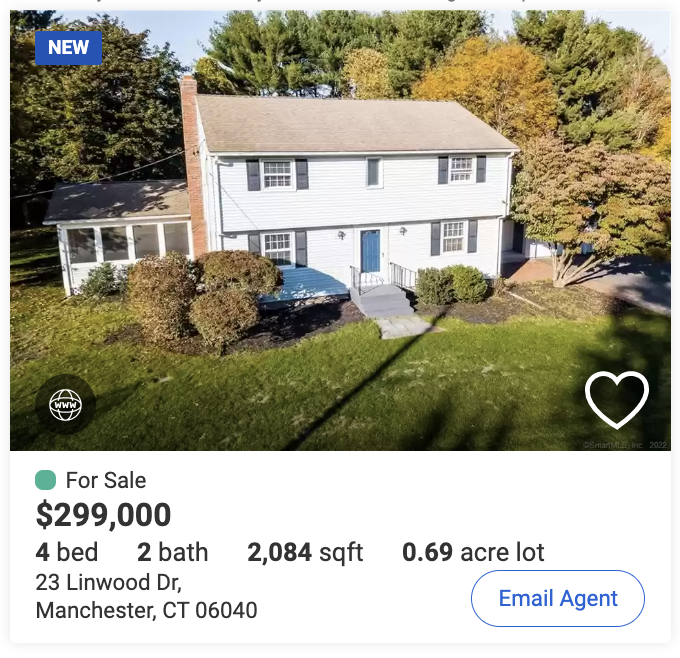

In [29]:
house_price('Connecticut', 4, 2, 2084, 0.69)

261504.19

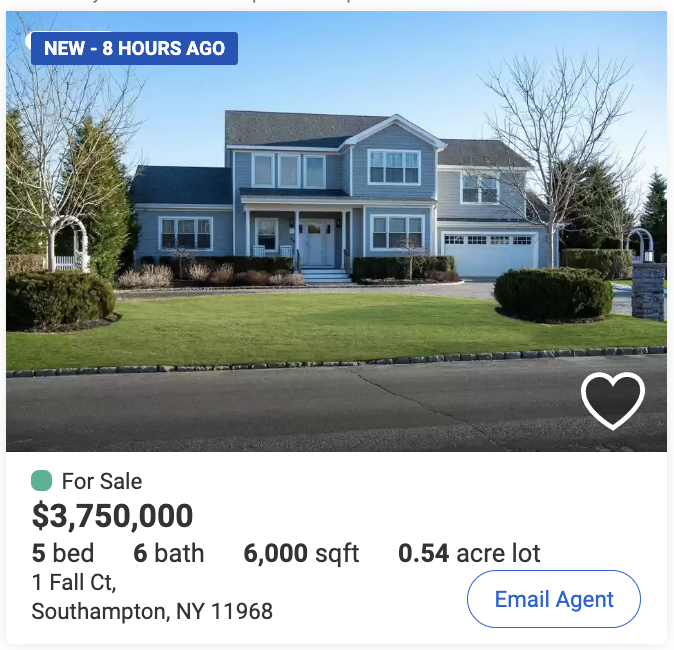

In [30]:
house_price('New York', 5, 6, 6000, 0.54)

2576543.95

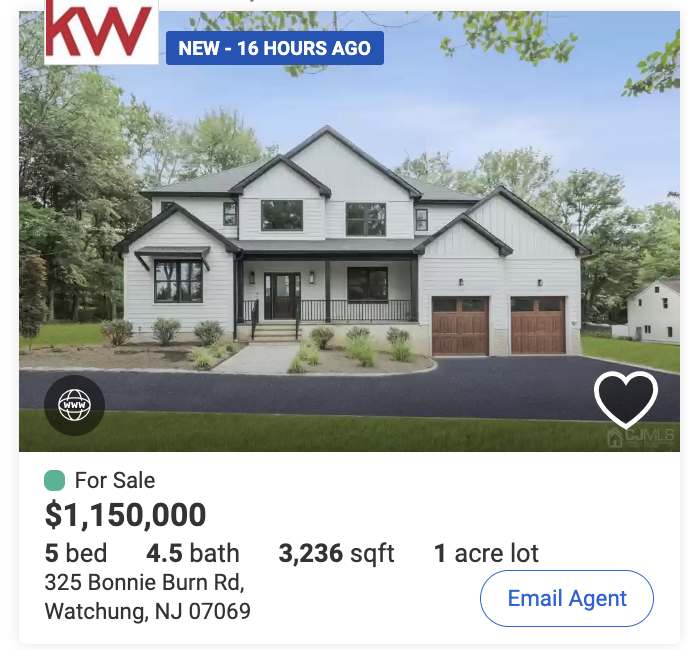

In [31]:
house_price('New Jersey', 5, 4.5, 3236, 1)

954083.74

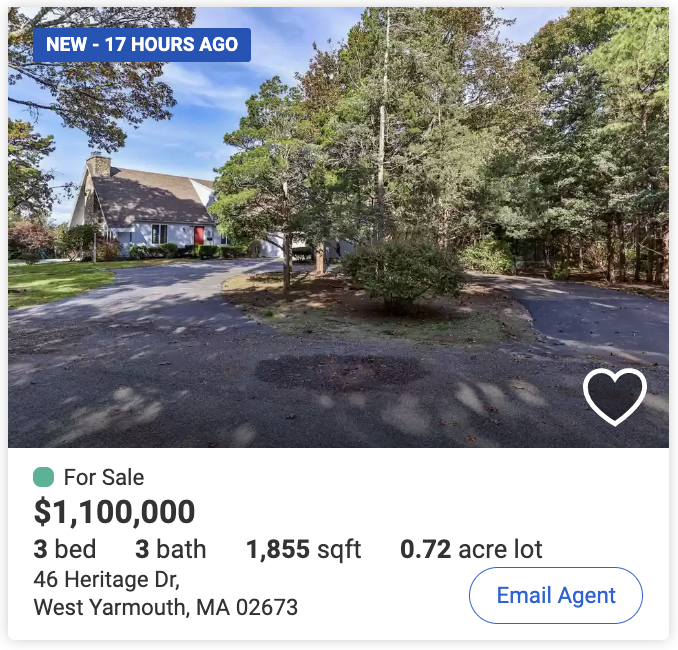

In [32]:
house_price('Massachusetts', 3, 3, 1855, 0.72)

941008.44